In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os;
os.chdir("/content/drive/MyDrive/Oviva_Challenge");

In [4]:
import json

# Read the JSON file into a Python object
with open('data.json') as f:
    data = json.load(f)

# Print the data
print(data)

[{'user_id': 'U010', 'log_time': '2020-01-15 08:30:00', 'description': 'A plate of scrambled eggs and toast.'}, {'user_id': 'U008', 'log_time': '2020-02-02 12:15:00', 'description': 'A bowl of vegetable stir-fry with quinoa.'}, {'user_id': 'U005', 'log_time': '2020-03-10 18:45:00', 'description': 'A serving of grilled chicken with steamed broccoli.'}, {'user_id': 'U003', 'log_time': '2020-04-05 13:00:00', 'description': 'A bowl of lentil soup with a side salad.'}, {'user_id': 'U009', 'log_time': '2020-05-20 20:00:00', 'description': 'A plate of spaghetti with marinara sauce and meatballs.'}, {'user_id': 'U002', 'log_time': '2020-06-08 09:30:00', 'description': 'A sandwich with turkey, cheese, lettuce, and whole-grain bread.'}, {'user_id': 'U005', 'log_time': '2020-07-17 15:45:00', 'description': 'A bowl of oatmeal topped with berries and almonds.'}, {'user_id': 'U005', 'log_time': '2020-08-22 19:20:00', 'description': 'A plate of salmon with roasted sweet potatoes.'}, {'user_id': 'U008

In [5]:
import pandas as pd
df = pd.DataFrame(data)
df

,user_id,log_time,description
0,U010,2020-01-15 08:30:00,A plate of scrambled eggs and toast.
1,U008,2020-02-02 12:15:00,A bowl of vegetable stir-fry with quinoa.
2,U005,2020-03-10 18:45:00,A serving of grilled chicken with steamed broc...
3,U003,2020-04-05 13:00:00,A bowl of lentil soup with a side salad.
4,U009,2020-05-20 20:00:00,A plate of spaghetti with marinara sauce and m...
...,...,...,...
719,U002,2020-03-05 17:05:00,A bowl of pho with rare beef slices and fresh ...
720,U003,2020-03-06 13:00:00,A slice of lemon meringue pie with a buttery c...
721,U009,2020-03-07 08:55:00,"A bagel with avocado, tomato, and a sprinkle o..."
722,U005,2020-03-08 18:50:00,A plate of shrimp scampi with linguine pasta.


Data extraction

In [6]:
import pandas as pd
food_corpus_df = pd.read_csv("food_corpus.csv")


all_values = []
for col in food_corpus_df.columns:
    all_values.extend(food_corpus_df[col].unique())
food_values = list(set(all_values))

print(food_values)

<ipython-input-6-2f06544adb30>:2: DtypeWarning: Columns (26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  food_corpus_df = pd.read_csv("food_corpus.csv")


['enchilada sauce', 'granular sucrolose sweetener', 'rockfish', 'snail shells', 'roast', 'breakfast sausages', 'white chocolate', 'mozzarella balls', 'mussels well scrubbed', 'yellow lentils', 'golden caster sugar', 'amaranth', 'hot pepperoni', 'mint', nan, 'seed', 'perch fillets', 'chocolate instant pudding', 'base', 'canned jalapeno peppers', 'frogs legs', 'pecans', 'red enchilada sauce', 'v8 juice', 'cilantro', 'yukon gold potatoes', 'pesto sauce', 'ground paprika', 'pita wedges', 'candlenuts', 'grit quick', 'fettuccine pasta', 'matzo cake meal', 'coffee', 'filipino eggplant', 'kokum', 'cactus', 'beans', 'sushi nori', 'quince', 'dried black mushrooms', 'whey', 'smoked trout fillets', 'riso', 'grape brandy', 'scallion', 'cho cho', 'granulated white sugar', 'nacho chips', 'annatto powder', 'wondra flour', 'kasseri', 'applesauce', 'low fat firm silken tofu', 'grapes', 'yellow curry paste', nan, 'spareribs', 'silver dragees', 'steel cut oats', 'chopped green chilies', 'blueberries', 'mi

Lemmatization

In [7]:
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

for index, row in df.iterrows():
    # Extract the sentences from the 'description' column
    sentence = (row['description']).lower()

    tokens = nltk.word_tokenize(sentence)
    filtered_tokens = []

    for token in tokens:
        # Lemmatize the token
        lemmatized_token = lemmatizer.lemmatize(token)

        # Check if the lemmatized token is in the food values list
        if lemmatized_token in food_values:
            filtered_tokens.append(lemmatized_token)

    food_items = ",".join(filtered_tokens)
    df.loc[index, 'Keywords'] = food_items
print(df)
datatypes = df.dtypes
datatypes

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


    user_id             log_time  \
0      U010  2020-01-15 08:30:00   
1      U008  2020-02-02 12:15:00   
2      U005  2020-03-10 18:45:00   
3      U003  2020-04-05 13:00:00   
4      U009  2020-05-20 20:00:00   
..      ...                  ...   
719    U002  2020-03-05 17:05:00   
720    U003  2020-03-06 13:00:00   
721    U009  2020-03-07 08:55:00   
722    U005  2020-03-08 18:50:00   
723    U006  2020-03-09 14:45:00   

                                           description  \
0                 A plate of scrambled eggs and toast.   
1            A bowl of vegetable stir-fry with quinoa.   
2    A serving of grilled chicken with steamed broc...   
3             A bowl of lentil soup with a side salad.   
4    A plate of spaghetti with marinara sauce and m...   
..                                                 ...   
719  A bowl of pho with rare beef slices and fresh ...   
720  A slice of lemon meringue pie with a buttery c...   
721  A bagel with avocado, tomato, and a spri

user_id        object
log_time       object
description    object
Keywords       object
dtype: object

In [8]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')


# english_stopwords = stopwords.words('english')
# english_stopwords.extend(['plate', 'bowl', 'spoon', 'serving','a','.',',','table','kitchen','set','ladle','cup','fork','enjoyed'])

# # Tokenize the sentence
# for index, row in df.iterrows():
#     # Extract the sentences from the 'description' column
#     sentence = (row['description']).lower()

#     tokens = nltk.word_tokenize(sentence)
#     filtered_tokens = [token for token in tokens if token in food_values]
#     food_items = ",".join(filtered_tokens)
#     df.loc[index,"Keywords"] = food_items


# print(df)

# datatypes = df.dtypes
# datatypes

Data Labelling

In [9]:
import datetime
for index, row in df.iterrows():
    time = datetime.datetime.strptime(row['log_time'], "%Y-%m-%d %H:%M:%S")
    if time.hour < 12:
        df.loc[index, "meal_type"] = "breakfast"
    elif time.hour < 18:
        df.loc[index, "meal_type"] = "lunch"
    else:
        df.loc[index, "meal_type"] = "dinner"

print(df)

    user_id             log_time  \
0      U010  2020-01-15 08:30:00   
1      U008  2020-02-02 12:15:00   
2      U005  2020-03-10 18:45:00   
3      U003  2020-04-05 13:00:00   
4      U009  2020-05-20 20:00:00   
..      ...                  ...   
719    U002  2020-03-05 17:05:00   
720    U003  2020-03-06 13:00:00   
721    U009  2020-03-07 08:55:00   
722    U005  2020-03-08 18:50:00   
723    U006  2020-03-09 14:45:00   

                                           description  \
0                 A plate of scrambled eggs and toast.   
1            A bowl of vegetable stir-fry with quinoa.   
2    A serving of grilled chicken with steamed broc...   
3             A bowl of lentil soup with a side salad.   
4    A plate of spaghetti with marinara sauce and m...   
..                                                 ...   
719  A bowl of pho with rare beef slices and fresh ...   
720  A slice of lemon meringue pie with a buttery c...   
721  A bagel with avocado, tomato, and a spri

In [10]:
#order by user id and then date
#df = df.set_index(['user_id','log_time']).sort_index()
df=df.sort_values(['user_id','log_time'])
print(df)
datatypes = df.dtypes
datatypes

    user_id             log_time  \
670    U001  2020-01-16 12:25:00   
36     U001  2020-01-17 11:00:00   
183    U001  2020-01-25 23:00:00   
406    U001  2020-01-28 03:15:00   
498    U001  2020-01-28 05:00:00   
..      ...                  ...   
301    U010  2020-12-08 20:30:00   
636    U010  2020-12-13 16:30:00   
266    U010  2020-12-15 18:45:00   
359    U010  2020-12-15 20:30:00   
520    U010  2020-12-16 00:00:00   

                                           description             Keywords  \
670          A cup of matcha latte and a mochi muffin.  matcha,mochi,muffin   
36   A sandwich with chicken Caesar wrap in a spina...      chicken,spinach   
183              A bowl and spoon on a kitchen island.                        
406      A bowl and a ladle placed on a kitchen shelf.                        
498      A bowl and a ladle placed on a kitchen shelf.                        
..                                                 ...                  ...   
301  A plate o

user_id        object
log_time       object
description    object
Keywords       object
meal_type      object
dtype: object

visualize the user's breakfast,lunch and dinner - U001

['tea', 'coffee', 'lemon', 'garlic', 'butter', 'shrimp', 'pasta', 'tomato', 'basil', 'soup', 'cheese', 'nut', 'coffee', 'nut', 'coffee', 'vegetable', 'lemon', 'fruit', 'fruit', 'fruit', 'cocoa', 'cocoa', 'spinach', 'cherry', 'tomato', 'coffee', 'black', 'coffee', 'cinnamon']
coffee       5
fruit        3
nut          2
lemon        2
cocoa        2
tomato       2
tea          1
black        1
cherry       1
spinach      1
vegetable    1
soup         1
cheese       1
basil        1
pasta        1
shrimp       1
butter       1
garlic       1
cinnamon     1
dtype: int64


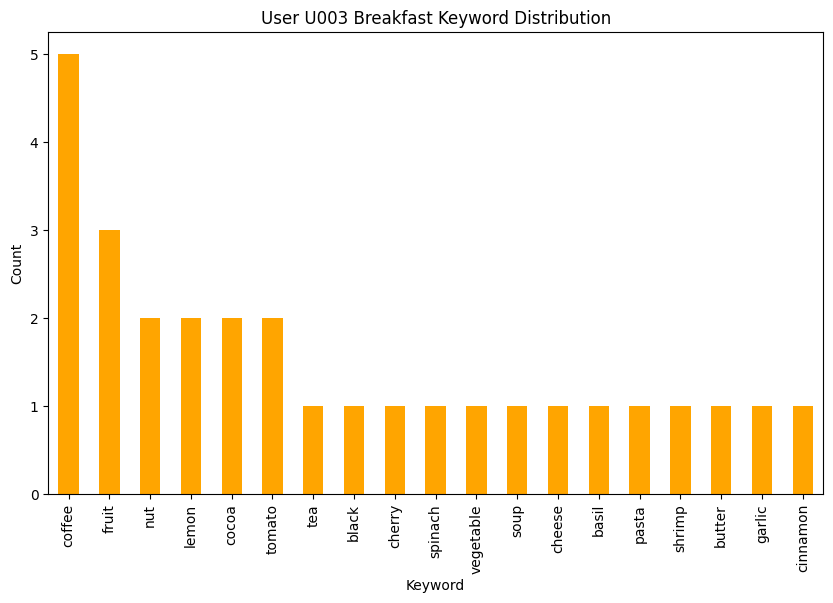

In [11]:
import matplotlib.pyplot as plt
user_data_breakfast = df[(df['user_id'] == 'U003') & (df['meal_type'] == 'breakfast')]

# Extract keywords during breakfast
result = []

for item in user_data_breakfast['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))

result = [item for item in result if item != '']
print(result)
# Create a DataFrame for breakfast keywords and their counts
breakfast_keywords_counts = pd.Series(result).value_counts()
print(breakfast_keywords_counts)
# Visualize breakfast keyword distribution
plt.figure(figsize=(10, 6))
breakfast_keywords_counts.plot(kind='bar', color='orange')
plt.title(f'User U003 Breakfast Keyword Distribution')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

User's meal logging behaviour

In [12]:
import datetime
from datetime import timedelta

df_filtered = df.loc[(df['user_id'] == 'U001')]

# Convert 'log_time' to datetime.time
df_filtered['log_time'] = pd.to_datetime(df_filtered['log_time']).dt.time

# Convert time objects to seconds
df_filtered['time_seconds'] = df_filtered['log_time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

average_breakfast_time = df_filtered[df_filtered['meal_type'] == 'breakfast']['time_seconds'].mean()
average_lunch_time = df_filtered[df_filtered['meal_type'] == 'lunch']['time_seconds'].mean()
average_dinner_time = df_filtered[df_filtered['meal_type'] == 'dinner']['time_seconds'].mean()

# Convert mean back to time object
average_breakfast_time = str(timedelta(seconds=average_breakfast_time))
average_lunch_time = str(timedelta(seconds=average_lunch_time))
average_dinner_time = str(timedelta(seconds=average_dinner_time))

print(f"Average breakfast time: {average_breakfast_time}")
print(f"Average lunch time: {average_lunch_time}")
print(f"Average dinner time: {average_dinner_time}")

Average breakfast time: 5:31:23.333333
Average lunch time: 15:04:46.363636
Average dinner time: 20:26:57.391304


<ipython-input-12-f7c085545274>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_time'] = pd.to_datetime(df_filtered['log_time']).dt.time
<ipython-input-12-f7c085545274>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_seconds'] = df_filtered['log_time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)


Most frequently consumed food items

['chicken', 'spinach', 'egg', 'spinach', 'cheese', 'soup', 'soup', 'beef', 'broccoli', 'jasmine', 'rice', 'nut', 'coffee', 'tea', 'black', 'coffee', 'fruit', 'baguette', 'grape', 'muffin', 'coffee', 'black', 'bean', 'soup', 'cream', 'salad', 'strawberry', 'vinaigrette', 'vegetable', 'ramen', 'topping', 'tilapia', 'asparagus', 'quinoa', 'tea', 'fruit', 'cheese', 'popcorn', 'turkey', 'cheese', 'lettuce', 'bread', 'vegetable', 'rice', 'fruit', 'soup', 'garlic', 'bread', 'coffee', 'tea', 'coffee', 'lemon', 'garlic', 'butter', 'shrimp', 'pasta', 'tomato', 'basil', 'soup', 'cheese', 'nut', 'coffee', 'nut', 'coffee', 'vegetable', 'lemon', 'fruit', 'fruit', 'fruit', 'cocoa', 'cocoa', 'spinach', 'cherry', 'tomato', 'coffee', 'black', 'coffee', 'cinnamon', 'topping', 'coffee', 'pea', 'stew', 'coffee', 'kale', 'pineapple', 'salmon', 'cream', 'cheese', 'dill', 'chamomile', 'tea', 'tea', 'fruit', 'fruit', 'fruit', 'salad', 'yogurt', 'honey', 'berry', 'granola', 'yogurt', 'berry', 'tea', 'tea', 'tun

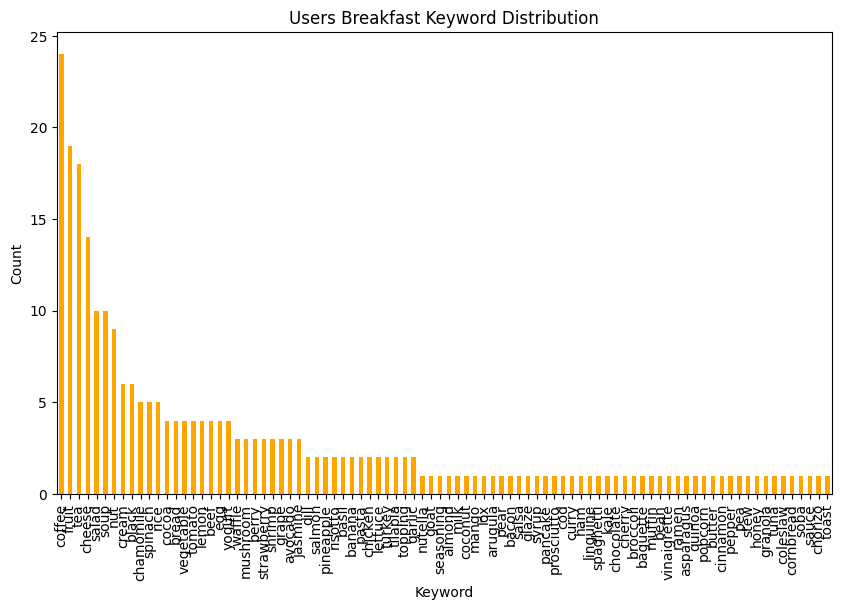

In [13]:
import matplotlib.pyplot as plt
user_data_breakfast = df[(df['meal_type'] == 'breakfast')]

# Extract keywords during breakfast
result = []

for item in user_data_breakfast['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))

result = [item for item in result if item != '']
print(result)
# Create a DataFrame for breakfast keywords and their counts
breakfast_keywords_counts = pd.Series(result).value_counts()
print(breakfast_keywords_counts)
# Visualize breakfast keyword distribution
plt.figure(figsize=(10, 6))
breakfast_keywords_counts.plot(kind='bar', color='orange')
plt.title(f'Users Breakfast Keyword Distribution')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

['matcha', 'mochi', 'muffin', 'fruit', 'coffee', 'coconut', 'curry', 'tofu', 'jasmine', 'rice', 'tea', 'tea', 'black', 'bean', 'corn', 'salad', 'lime', 'vinaigrette', 'cocoa', 'cinnamon', 'black', 'coffee', 'pork', 'potato', 'tea', 'tea', 'swordfish', 'salmon', 'quinoa', 'peppermint', 'tea', 'honey', 'tea', 'lentil', 'soup', 'bread', 'chicken', 'potato', 'ham', 'cheese', 'turmeric', 'blueberry', 'muffin', 'red', 'cake', 'cream', 'cheese', 'frosting', 'coffee', 'coffee', 'coffee', 'turkey', 'swiss', 'cheese', 'cranberry', 'sauce', 'eggplant', 'spaghetti', 'lavender', 'beef', 'potato', 'black', 'bean', 'salsa', 'nut', 'coffee', 'chamomile', 'tea', 'tea', 'honey', 'salmon', 'asparagus', 'tomato', 'basil', 'vegetable', 'soup', 'tofu', 'soup', 'garlic', 'wasabi', 'soy', 'sauce', 'pepperoni', 'salad', 'quinoa', 'salad', 'avocado', 'cherry', 'tomato', 'beef', 'tzatziki', 'sauce', 'bread', 'pecan', 'cream', 'matcha', 'tea', 'mochi', 'lemon', 'meringue', 'crust', 'water', 'lime', 'lentil', 'sou

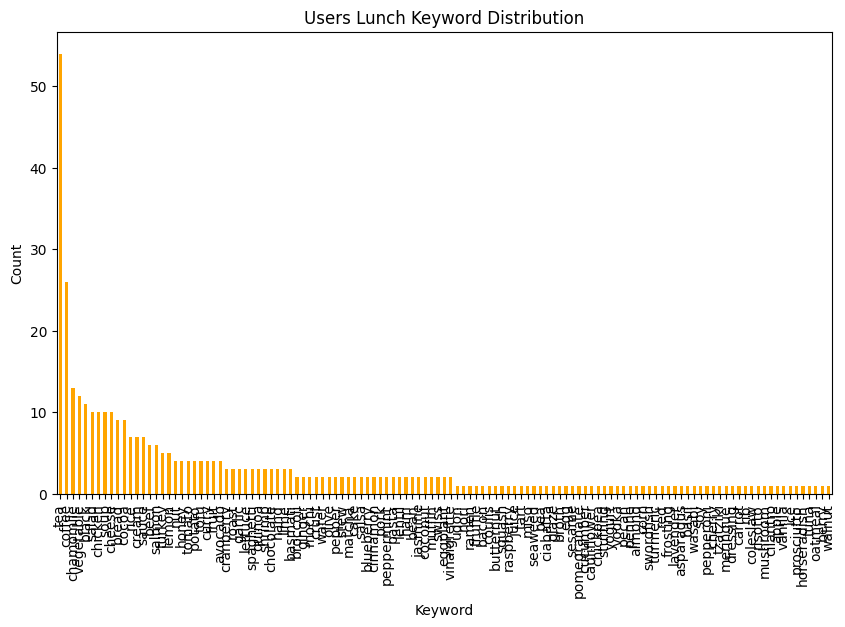

In [14]:
user_data_lunch = df[(df['meal_type'] == 'lunch')]

# Extract keywords during lunch
result = []

for item in user_data_lunch['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))

result = [item for item in result if item != '']
print(result)
# Create a DataFrame for lunch keywords and their counts
lunch_keywords_counts = pd.Series(result).value_counts()
print(lunch_keywords_counts)
# Visualize lunch keyword distribution
plt.figure(figsize=(10, 6))
lunch_keywords_counts.plot(kind='bar', color='orange')
plt.title(f'Users Lunch Keyword Distribution')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

['chicken', 'curry', 'rice', 'kale', 'salad', 'shrimp', 'coffee', 'coffee', 'coffee', 'soup', 'soba', 'salad', 'sesame', 'dressing', 'nut', 'coffee', 'black', 'coffee', 'tea', 'cocoa', 'coffee', 'coffee', 'garlic', 'bread', 'vegetable', 'vegetable', 'garlic', 'bread', 'coffee', 'tea', 'tea', 'chicken', 'tea', 'tea', 'tea', 'vegetable', 'tofu', 'rice', 'fruit', 'salad', 'fruit', 'fruit', 'fruit', 'fruit', 'cocoa', 'cocoa', 'cocoa', 'cocoa', 'vegetable', 'tofu', 'coffee', 'chicken', 'garlic', 'bread', 'coffee', 'tea', 'tea', 'tea', 'salad', 'salmon', 'chicken', 'vegetable', 'tzatziki', 'sauce', 'soup', 'tea', 'fruit', 'salad', 'black', 'coffee', 'chamomile', 'tea', 'beef', 'broccoli', 'jasmine', 'rice', 'fruit', 'cocoa', 'cocoa', 'butternut', 'squash', 'risotto', 'garlic', 'bread', 'coffee', 'butternut', 'squash', 'soup', 'coffee', 'coffee', 'lime', 'soup', 'ziti', 'orange', 'juice', 'salsa', 'guacamole', 'tea', 'tea', 'black', 'coffee', 'chamomile', 'tea', 'fruit', 'salad', 'cocoa', 'sa

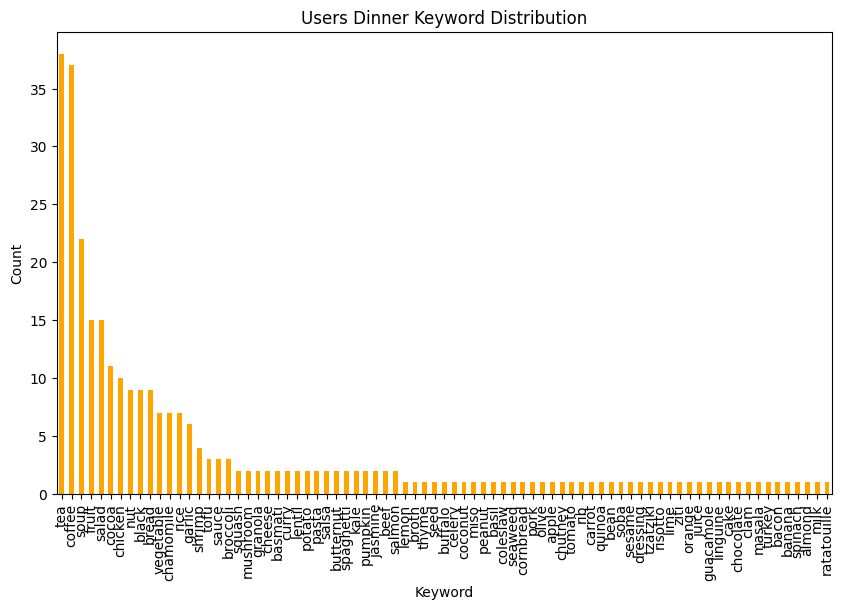

In [15]:
user_data_dinner = df[(df['meal_type'] == 'dinner')]

# Extract keywords during dinner
result = []

for item in user_data_dinner['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))

result = [item for item in result if item != '']
print(result)
# Create a DataFrame for dinner keywords and their counts
dinner_keywords_counts = pd.Series(result).value_counts()
print(dinner_keywords_counts)
# Visualize dinner keyword distribution
plt.figure(figsize=(10, 6))
dinner_keywords_counts.plot(kind='bar', color='orange')
plt.title(f'Users Dinner Keyword Distribution')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

Build a system to do this analysis at scale (eg. 100K users logging meals over a
year)

Find patterns in meal description on weekdays and weekends for all users

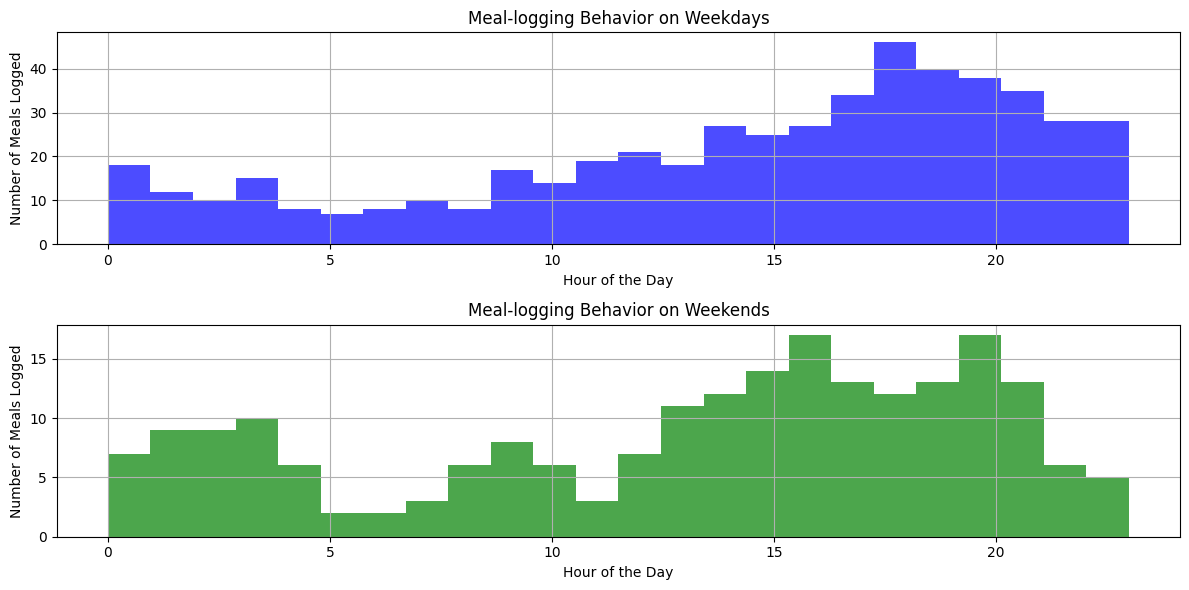

In [16]:
import matplotlib.pyplot as plt
df['log_time'] = pd.to_datetime(df['log_time'])
df['day_type'] = df['log_time'].dt.weekday.apply(lambda x: 'weekday' if x < 5 else 'weekend')

user_data_weekday = df[(df['day_type'] == 'weekday')]
user_data_weekend = df[(df['day_type'] == 'weekend')]
# Plotting
plt.figure(figsize=(12, 6))

# Plot for weekdays
plt.subplot(2, 1, 1)
plt.hist(user_data_weekday['log_time'].dt.hour, bins=24, color='blue', alpha=0.7)
plt.title('Meal-logging Behavior on Weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Meals Logged')
plt.grid(True)

# Plot for weekends
plt.subplot(2, 1, 2)
plt.hist(user_data_weekend['log_time'].dt.hour, bins=24, color='green', alpha=0.7)
plt.title('Meal-logging Behavior on Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Meals Logged')
plt.grid(True)

plt.tight_layout()
plt.show()